In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import optimizers
import os
import cv2
from sklearn import metrics
import warnings
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=FutureWarning)
import pickle

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            data.append([resized_arr, class_num])
        except Exception as e:
            print(e)
  return np.array(data)

In [ ]:
train_path = '/content/drive/MyDrive/chest_xray/train'
test_path = '/content/drive/MyDrive/chest_xray/test'

In [ ]:
test_ds = get_training_data('/content/drive/MyDrive/X-ray dataset/chest_xray/test')
train_ds = get_training_data('/content/drive/MyDrive/X-ray dataset/chest_xray/train')
val_ds = get_training_data('/content/drive/MyDrive/X-ray dataset/chest_xray/val')

<ipython-input-4-4ef29edd5fc4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train_ds:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test_ds:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val_ds:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

CNN:

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Convolution2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(tf.keras.layers.Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(tf.keras.layers.Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(tf.keras.layers.Convolution2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(tf.keras.layers.Convolution2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(tf.keras.layers.Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

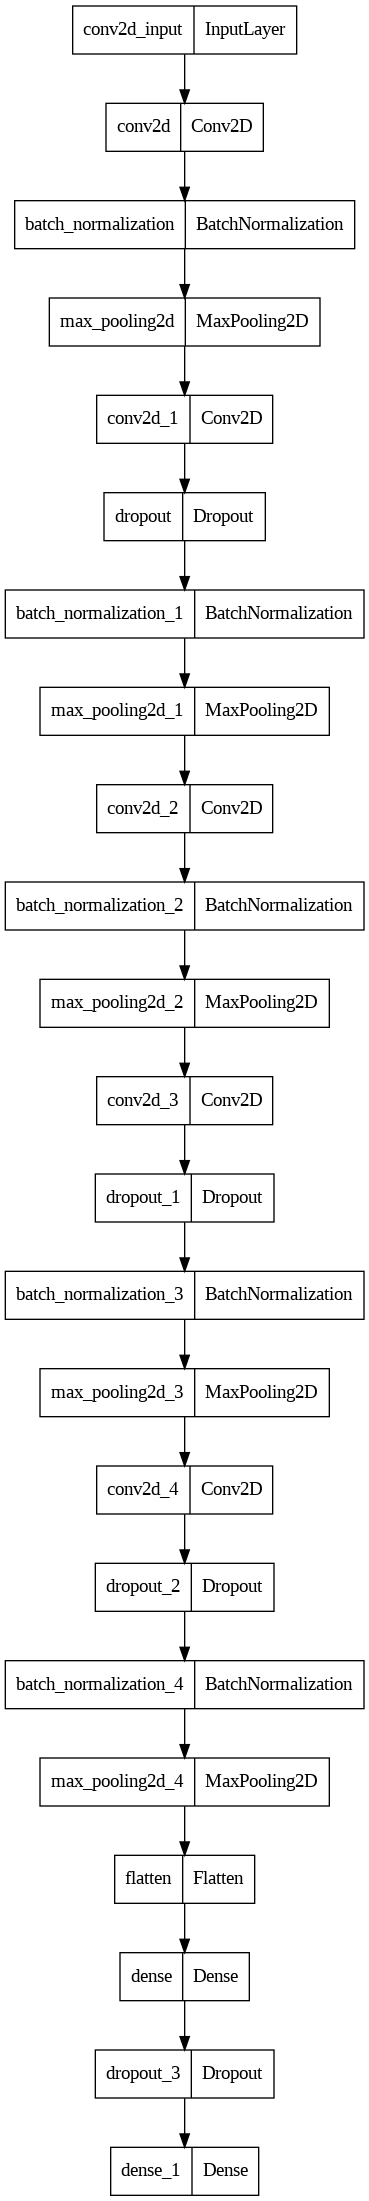

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
input_size = (150,150)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# fit the cnn model to the trainig set and testing it on the test set
model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/12
164/164 [==============================] - 355s 2s/step - loss: 0.5365 - accuracy: 0.8467 - val_loss: 7.5761 - val_accuracy: 0.5000
Epoch 2/12
164/164 [==============================] - 350s 2s/step - loss: 0.2703 - accuracy: 0.8928 - val_loss: 33.2250 - val_accuracy: 0.5000
Epoch 3/12
164/164 [==============================] - 356s 2s/step - loss: 0.2172 - accuracy: 0.9238 - val_loss: 2.2400 - val_accuracy: 0.8125
Epoch 4/12
164/164 [==============================] - 355s 2s/step - loss: 0.2002 - accuracy: 0.9303 - val_loss: 0.7726 - val_accuracy: 0.5625
Epoch 5/12
164/164 [==============================] - 351s 2s/step - loss: 0.1888 - accuracy: 0.9377 - val_loss: 20.1304 - val_accuracy: 0.5625
Epoch 6/12
164/164 [==============================] - 359s 2s/step - loss: 0.1747 - accuracy: 0.9385 - val_loss: 9.4176 - val_accuracy: 0.5000
Epoch 7/12
164/164 [==============================] - 354s 2s/step - loss: 0.1601 - accuracy: 0.9494 - val_loss: 0.7427 - val_accuracy: 0.68

Test Results:

In [ ]:
model.save('final_cnn1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# pickle.dump(model, open('final_cnn1.h5','wb'))

In [ ]:
# pickle.dump(model, open('final_cnn.pkl','wb'))

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/final_cnn.pkl', 'rb'))

In [ ]:
x_test[0].shape

(150, 150, 1)

In [ ]:
preds = model.predict(x_test)
#preds = preds.reshape(1,-1)[0]

20/20 [==============================] - 10s 488ms/step


In [ ]:
y_pred_test = np.empty_like(preds)
y_pred_test[:] = (preds[:] > 0.5) * 1

In [ ]:
print(classification_report(y_test, y_pred_test, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.85      0.98      0.91       390
   Normal (Class 1)       0.95      0.72      0.82       234

           accuracy                           0.88       624
          macro avg       0.90      0.85      0.86       624
       weighted avg       0.89      0.88      0.88       624



In [ ]:
print(confusion_matrix(y_test, y_pred_test))

[[381   9]
 [ 66 168]]


In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

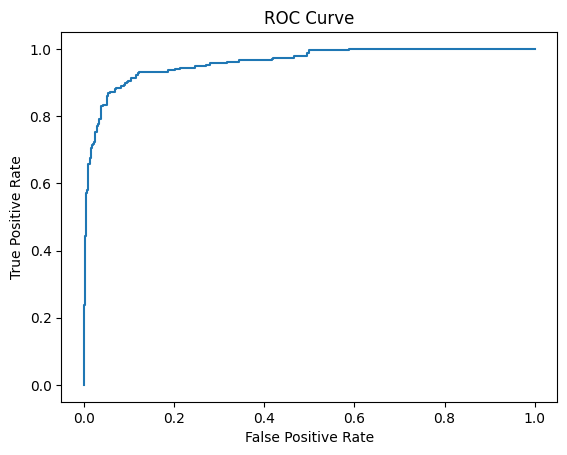

In [ ]:
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Inference:

In [ ]:
test_image = image.load_img('/content/drive/MyDrive/X-ray dataset/chest_xray/test/NORMAL/IM-0001-0001.jpeg', target_size= input_size)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

1/1 [==============================] - 0s 195ms/step


In [ ]:
training_set.class_indices

In [ ]:
if result [0][0] == 1:
  prediction = 'PNEUMONIA'
else:
  prediction = 'NORMAL'

In [ ]:
prediction